# Function Approximation with PyTorch

The objective of this tutorial is to learn the function

$$u = sin(x), \quad x\in(0, 2\pi)$$

by using feed-forward dense neural networks implemented within the framework of PyTorch.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [17]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [18]:
# Define the exact solution
def exact_solution(x):
    return torch.sin(x)

$\mathbf{\text{Step 1: Dataset Generation}}$

We are going to use the training set 

$$S=\{ (x_i, u_i), ~i=1,...,n \}$$ 

with 

$$x_i \sim U\big(0, 2\pi\big), \quad u_i \sim N\big(sin(x_i), \sigma\big).$$

Here, $U(a,b)$ is a uniform random distribution between $a$ and $b$, and $N(\mu, \sigma)$ is a normal distribution with mean $\mu$ and standard deviation $\sigma$

Text(0, 0.5, 'u')

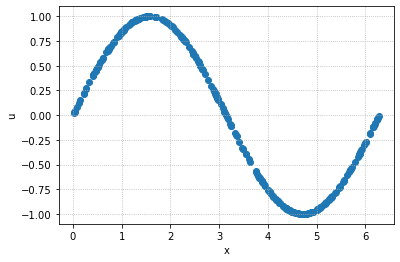

In [19]:
# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"
# Random Seed for dataset generation
sampling_seed = 78
torch.manual_seed(sampling_seed)

# Number of training samples
n_samples = 300
# Noise level
sigma = 0.0

x = 2*np.pi*torch.rand((n_samples, 1))
y = exact_solution(x)*(1 + sigma*torch.randn(x.shape))


batch_size = n_samples
training_set = DataLoader(torch.utils.data.TensorDataset(x, y), batch_size=batch_size, shuffle=True)

plt.grid(True, which="both", ls=":")
plt.scatter(x,y)
plt.xlabel("x")
plt.ylabel("u")

$\mathbf{\text{Step 2: Model Generation}}$

We use feedforward neural (also termed as a multi-layer perceptron) network to approximate the function

$$ u = sin(x)$$

Given an input $x \in D \subset R^n$, a feedforward neural network transforms it to an output $u_\theta(x)\in R^m$, through a layer of units (neurons) which compose of either affine-linear maps between units (in successive layers) or scalar non-linear activation functions within units, resulting in the representation,

$$u_{\theta}(x) = C_K \circ A \circ C_{K-1}\ldots \ldots \ldots \circ A\circ C_2 \circ A\circ C_1(x).$$

Here, $\circ$ refers to the composition of functions and $A$ is a scalar (non-linear) activation function. For any $1 \leq k \leq K$, we define

$$
C_k z_k = W_k z_k + b_k, \quad {\rm for} ~ W_k \in R^{d_{k+1} \times d_k}, z_k \in R^{d_k}, b_k \in R^{d_{k+1}}.
$$

We also denote, 
$$
\theta = \{W_k, b_k\}, \theta_W = \{ W_k \}\quad \forall~ 1 \leq k \leq K,
$$
to be the concatenated set of (tunable) weights for our network.

In [20]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Sigmoid()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        
        for name, param in self.named_parameters():
            #if 'input_layer' in name and 'bias' in name:
                # nn.init.zeros_(param)
                # print(param)
            print(name,param.size())


    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

def NeuralNet_Seq(input_dimension, output_dimension, n_hidden_layers, neurons):
    modules = list()
    modules.append(nn.Linear(input_dimension, neurons))
    modules.append(nn.Tanh())
    for _ in range(n_hidden_layers):
        modules.append(nn.Linear(neurons, neurons))
        modules.append(nn.Tanh())
    modules.append(nn.Linear(neurons, output_dimension))
    model =  nn.Sequential(*modules)
    return model

  


In [21]:
# Model definition
my_network = NeuralNet(input_dimension=x.shape[1], output_dimension=y.shape[1], n_hidden_layers=4, neurons=20)
# my_network = NeuralNet_Seq(input_dimension=x.shape[1], output_dimension=y.shape[1], n_hidden_layers=4, neurons=20)

input_layer.weight torch.Size([20, 1])
input_layer.bias torch.Size([20])
hidden_layers.0.weight torch.Size([20, 20])
hidden_layers.0.bias torch.Size([20])
hidden_layers.1.weight torch.Size([20, 20])
hidden_layers.1.bias torch.Size([20])
hidden_layers.2.weight torch.Size([20, 20])
hidden_layers.2.bias torch.Size([20])
hidden_layers.3.weight torch.Size([20, 20])
hidden_layers.3.bias torch.Size([20])
output_layer.weight torch.Size([1, 20])
output_layer.bias torch.Size([1])


#### Weight initialization
The initialization of the weights is of fundamental importance for the proper
training of the model, in particular when it comes to non-convex optimization. A common way of initializing the weights is the following (Xavier initialization):

$$W_k \sim N(0, \sigma^k_W), \quad \sigma_W^k= g \sqrt{\frac{2}{d_k + d_{k+1}}}$$

or 
$$W_k \sim U(-l^k_W,l^k_W), \quad l^k_W= g \sqrt{\frac{6}{d_k + d_{k+1}}}$$

with $g=1$ for hyperbolic tangent activation and $g = \sqrt{2}$ for ReLU activation function.

This weights initialization guarantees a constant variance  of the variables $z_k$ as the
inputs are forward propagated (check http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) 

In [22]:
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)
# Model definition

# Predict network value of x
print(torch.mean(my_network(x)),torch.std(my_network(x)))
# print(my_network(x))

tensor(-1.7800, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<StdBackward>)


$\mathbf{\text{Step 3: Model Training}}$

The neural network $u_{\theta}$ depends on the tuning parameter $\theta \in \Theta$ of weights and biases. Within the standard paradigm of {deep learning}, one {trains} the network by finding tuning parameters $\theta$ such that a suitable loss function $J(\theta)$ is minimized.

$${\rm Find}~\theta^{\ast} \in \Theta:\quad \theta^{\ast} = {\rm arg}\min\limits_{\theta \in \Theta} \left( J(\theta)\right).$$

The loss function, for instance, can be chosen as the mean square error between the neural network and the underlying target:

$$ J(\theta) = \sum_{i}^n \Big(u_i - u_\theta(x_i)\Big)^2$$

The optimization process is realized with the gradient descent (or more precisely with variants of the gradient descent such as Adam or SGD).

In [23]:
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")

#### LBFGS Optimizer (Generic Idea)

Let us consider a generic function $f: x\mapsto f(x)$, $x\in R^d$ and $f(x)\in R$. The taylor approximation of $\nabla f$ in a neighbourhood of $x_k$ is

$$\nabla f(x_k + \delta x) = \nabla f(x_k) + H_k\delta x$$

with $H_k$ being the Hessian of $f$ at $x_k$.
We would like to find the vector $ \delta x$ such that

$$\nabla f(x_k + \delta x) = 0$$

This leads to 

$$x_{k+1} = x_k - H_k^{-1}\nabla f \quad \text{(Newton Method)}$$

The idea of Quasi-Newton methods (LBFGS belong to this class) is to approximate $H$ with a positive definite matrix $B$, which is easier to compute:

$$x_{k+1} = x_k  = - B_{k}^{-1}\nabla f \quad \text{(Quasi - Newton Method)}$$

The matrix B has to satisfy the following conditions:
- Positive definiteness
- $B_k$ and $B_{k+1}$ "sufficiently close"
- Secant equation  $$ B_{k+1}[x_{k+1} - x_k] = \nabla f(x_{k+1}) - \nabla f(x_{k})$$

A constraint minimization problem can be set to find the update formula for $B_k$
(check https://towardsdatascience.com/bfgs-in-a-nutshell-an-introduction-to-quasi-newton-methods-21b0e13ee504)

In [24]:
def fit(model, training_set, num_epochs, optimizer, p, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                u_pred_ = model(x_train_)
                # Item 1. below
                loss = torch.mean((u_pred_.reshape(-1, ) - u_train_.reshape(-1, ))**p)
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)
            
        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


1. Compute the loss function over the batch $j$:
$J_S(\theta)=\sum_{x_i \in {S}_j}^n \Big(u_i - u_\theta(x_i)\Big)^2$

2. Compute the gradient of $J_S(\theta)$ with respect to the network parameters:  $\nabla_\theta J_S(\theta)$

3. Update the parameters according to the chosen optimizer, for instance for minibatch gradient descent $\theta_{k+1} = \theta_{k} - \eta \nabla_\theta J_S(\theta_{k}) $ with $k=1,...,(n_{epoch} n_{batch})$ and $\eta$ being the learnng rate (argument $lr$ in the optimizer).

In [25]:
n_epochs = 2500
history = fit(my_network, training_set, n_epochs, optimizer_, p=2, verbose=True)

################################  0  ################################
Loss:  3.632657527923584
################################  1  ################################
Loss:  3.5543012619018555
################################  2  ################################
Loss:  2.9815280437469482
################################  3  ################################
Loss:  2.507002592086792
################################  4  ################################
Loss:  2.1166927814483643
################################  5  ################################
Loss:  1.7984837293624878
################################  6  ################################
Loss:  1.5408889055252075
################################  7  ################################
Loss:  1.3334780931472778
################################  8  ################################
Loss:  1.1671150922775269
################################  9  ################################
Loss:  1.0340156555175781
################################  10  ####

$\mathbf{\text{Step 3: Model Evaluation}}$

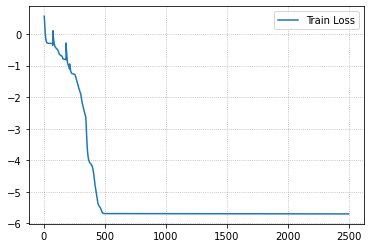

In [26]:
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1,n_epochs+1), np.log10(history), label="Train Loss")
plt.legend()

In [27]:
x_test = torch.linspace(0, 2*np.pi, 10000).reshape(-1,1)
y_test = exact_solution(x_test).reshape(-1,)

In [28]:
y_test_pred = my_network(x_test).reshape(-1,)

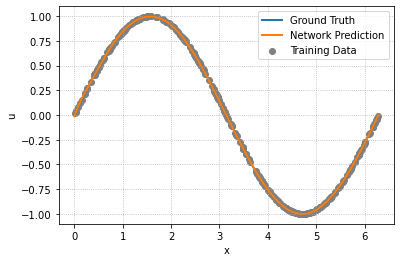

In [29]:
plt.grid(True, which="both", ls=":")
plt.scatter(x, y, label="Training Data", marker="o", color="grey")
plt.plot(x_test, y_test, label="Ground Truth",lw=2)
plt.plot(x_test, y_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [30]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((y_test_pred - y_test)**2)/torch.mean(y_test**2)
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.0005040930773247965 %


### Exercises
1. The model training is particularly sensitive to the initialization of the weights, as different initial values of the weights can lead to different local minima. This is governed by the parameter $retrain$. Try to change the value $retrain$ and test it by yourself.

2. Try to use the mean absolute error loss $J(\theta) = \sum_{i}^n \big|u_i - u_\theta(x_i)\big|$.

3. The resulting geenralization capability of the model also depends on the number of training samples $n_{samples}$ and the data noise $\sigma$. Train the model for $\sigma=0, 0.25$ and $n_{samples}=20, 50, 100, 200$. 

4. For high values of $\sigma$ and low values of $n_{samples}$ the data overfitting occurs and the generalization capability of the model deteriorates. A common approach to prevent overfitting is to add regularization, i.e. we seek to find,

    $$
    \label{eq:lf2}
    \theta^{\ast} = {\rm arg}\min\limits_{\theta \in \Theta} \left(J(\theta) + \lambda_{reg} J_{reg}(\theta) \right).
    $$
    Here, $J_{reg}:\Theta \to R$ is a {regularization} (penalization) term. A popular choice is to set  $J_{reg}(\theta) = \|\theta\|^q_q$ for either $q=1$ (to induce sparsity) or $q=2$. The parameter $0 \leq \lambda_{reg} \ll 1$ balances the regularization term with the actual loss $J$.
    
    $L^2$-penalty can be added by adjusting the optimizer argument weight_decay (check https://pytorch.org/docs/stable/optim.html). One additional alternative is to use the following function
    ```python
    def regularization(model, order):
        reg_loss = 0
        for name, param in model.named_parameters():
            if 'weight' in name or 'bias' in name:
                reg_loss = reg_loss + torch.norm(param, order)
        return reg_loss
    ```
    that returns the term $J_{reg}(\theta)$. Try to improve the training results for $\sigma=0.25$ and $n_{samples}=20$ by using weight regularization